# Explore here

In [214]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_regression
from sklearn.datasets import load_wine

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [215]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv"
pd.read_csv(url, sep=";", encoding= "utf-8").to_csv('../data/winequality-red.csv', index=False)

In [216]:
df = pd.read_csv("../data/winequality-red.csv")

In [217]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


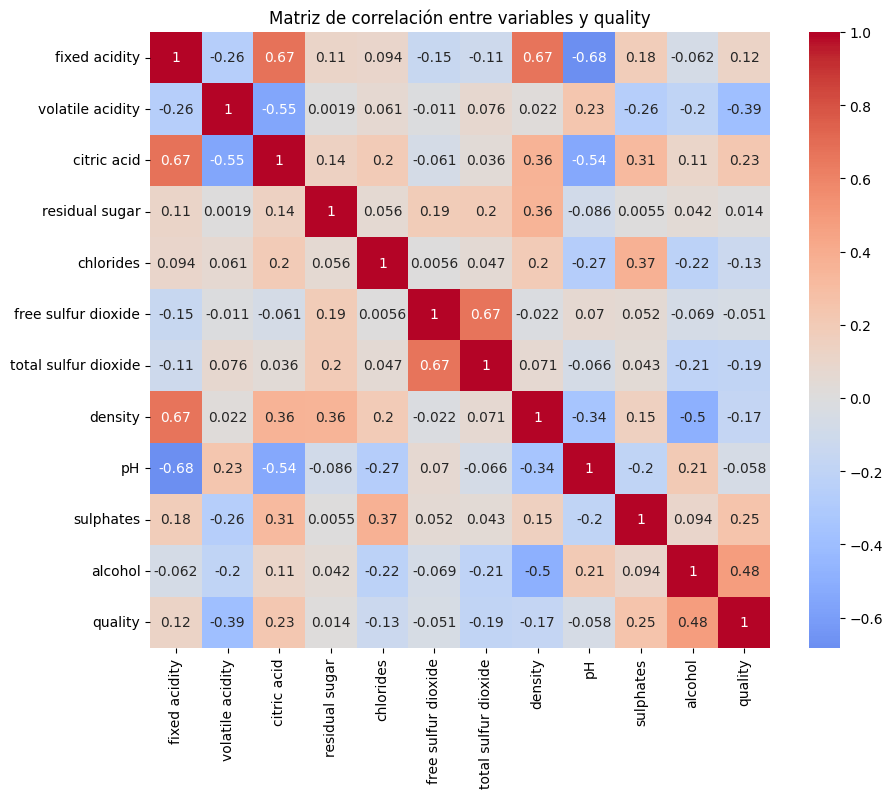

In [218]:
corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación entre variables y quality")
plt.show()

In [219]:
conditions = [
    (df["quality"] <= 4),
    (df["quality"].between(5, 6)),
    (df["quality"] >= 7)
]
labels = ["baja", "media", "alta"]

df["quality_label"] = np.select(conditions, labels, default="desconocido")
print(df["quality_label"].value_counts())

quality_label
media    1319
alta      217
baja       63
Name: count, dtype: int64


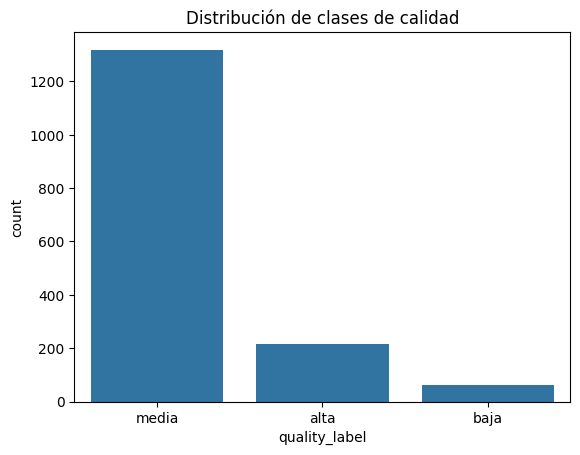

In [220]:
sns.countplot(x=df["quality_label"])
plt.title("Distribución de clases de calidad")
plt.show()


In [221]:
df["label"] = pd.cut(
    df["quality"],
    bins=[2, 4, 6, 8],              # rangos: (2-4], (4-6], (6-8]
    labels=["baja", "media", "alta"],
    include_lowest=True
)

# Ver distribución
print(df["label"].value_counts())

label
media    1319
alta      217
baja       63
Name: count, dtype: int64


In [222]:
# X SOLO numéricas
X = df.drop(["quality", "label"], axis=1).select_dtypes(include=["int64", "float64"])

# y en enteros (no strings)
le = LabelEncoder()
y = le.fit_transform(df["label"])  # baja/media/alta -> 0/1/2 (orden según le.classes_)
print("Clases:", le.classes_)

cnt = Counter(y)
max_n = max(cnt.values())
target = {cls: max_n for cls in cnt.keys()}  # e.g., {0: max_n, 1: max_n, 2: max_n}

smote = SMOTE(sampling_strategy=target, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Distribución tras SMOTE:", pd.Series(y_res).value_counts())



X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# **Escalar sin fuga** (fit en train, transform en test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



Clases: ['alta' 'baja' 'media']
Distribución tras SMOTE: 2    1319
0    1319
1    1319
Name: count, dtype: int64


In [223]:
# **Entrenar KNN**
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# **Evaluación**
y_pred = knn.predict(X_test_scaled)
print("Reporte de clasificación:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))


Reporte de clasificación:
               precision    recall  f1-score   support

        alta       0.81      0.99      0.89       264
        baja       0.87      0.99      0.92       264
       media       0.97      0.62      0.76       264

    accuracy                           0.87       792
   macro avg       0.88      0.87      0.86       792
weighted avg       0.88      0.87      0.86       792

Matriz de confusión:
 [[262   0   2]
 [  0 261   3]
 [ 60  40 164]]


In [224]:
k_values = [3, 5, 7, 9, 11, 13, 15]

results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k,weights="distance", metric="euclidean")
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")  # opcional

    results.append({
        "k": k,
        "accuracy": acc,
        "macro_f1": macro_f1  # quítalo si no lo quieres
    })

# Ordenar por accuracy
res_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
print("Resultados por k (ordenado por accuracy):\n", res_df)

# Mejor k según accuracy
best_k = int(res_df.iloc[0]["k"])
print(f"\nMejor k según accuracy: {best_k}")

# Re-entrenar y evaluar
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights="distance", metric="euclidean")
knn_best.fit(X_train_scaled, y_train)
y_pred_best = knn_best.predict(X_test_scaled)

print("\nReporte de clasificación (mejor k por accuracy):\n",
      classification_report(y_test, y_pred_best, target_names=le.classes_))
print("Matriz de confusión (mejor k):\n", confusion_matrix(y_test, y_pred_best))


Resultados por k (ordenado por accuracy):
     k  accuracy  macro_f1
0   3  0.911616  0.908430
2   7  0.906566  0.903008
1   5  0.905303  0.901526
3   9  0.901515  0.897209
5  13  0.893939  0.888648
4  11  0.890152  0.884599
6  15  0.886364  0.880530

Mejor k según accuracy: 3

Reporte de clasificación (mejor k por accuracy):
               precision    recall  f1-score   support

        alta       0.86      0.99      0.92       264
        baja       0.92      1.00      0.96       264
       media       0.98      0.75      0.85       264

    accuracy                           0.91       792
   macro avg       0.92      0.91      0.91       792
weighted avg       0.92      0.91      0.91       792

Matriz de confusión (mejor k):
 [[261   0   3]
 [  0 263   1]
 [ 44  22 198]]
